# 1 Data Wrangling and EDA

## 1.1 Preparation

### 1.1.1 Importing Packages

In [1]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from PIL import Image

### 1.1.2 Loading Metadata

In [2]:
# Loading data
data = pd.read_csv('../data/raw/Data_Entry_2017_v2020.csv')
data.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


## 1.2 Labeling Data

In [3]:
# Label Cardiomegaly if 'Finding Labels' contains 'Cardiomegaly'
data['Cardiomegaly'] = data['Finding Labels'].str.contains('Cardiomegaly')

In [4]:
# Determine value counts for labels
data.value_counts('Cardiomegaly')

Cardiomegaly
False    109344
True       2776
Name: count, dtype: int64

In [5]:
data.value_counts('Cardiomegaly', normalize=True) * 100

Cardiomegaly
False    97.524081
True      2.475919
Name: proportion, dtype: float64

Only 2.48% of the images are diagnosed with cardiomegaly, which is 2776 of the 112,120 images.

## 1.3 Exploring the data

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Cardiomegaly                 112120 non-null  bool   
dtypes: bool(1), float64(2), int64(5), object(4)
memory usage: 

In [7]:
# Check missing values
data.isna().sum()

Image Index                    0
Finding Labels                 0
Follow-up #                    0
Patient ID                     0
Patient Age                    0
Patient Gender                 0
View Position                  0
OriginalImage[Width            0
Height]                        0
OriginalImagePixelSpacing[x    0
y]                             0
Cardiomegaly                   0
dtype: int64

There are no missing values in the data.

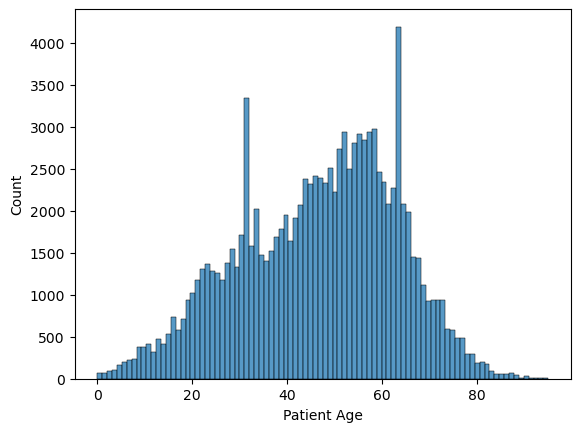

In [8]:
# View ages of patients
sns.histplot(data=data, x='Patient Age');

The majority of patients are between 50-60 years old.

In [9]:
def plot_proportion(df, col):
    """Plots the proportion of a category 'col' for each class in 'Cardiomegaly'."""
    x, y, hue = col, "Proportion", "Cardiomegaly"
    hue_order = [True, False]

    (df[x]
     .groupby(df[hue])
     .value_counts(normalize=True)
     .rename(y)
     .reset_index()
     .pipe((sns.barplot, "data"), x=x, y=y, hue=hue));

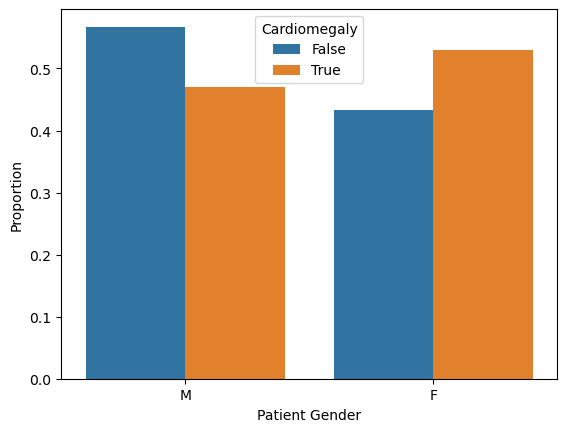

In [10]:
# Plot the proportion for Patient Gender
plot_proportion(data, 'Patient Gender')

Of patients with cardiomegaly, there is a higher percentage of female patients than male while for negative patients, there are more male patients. In both cases, the difference between the proportions is roughly 10%.

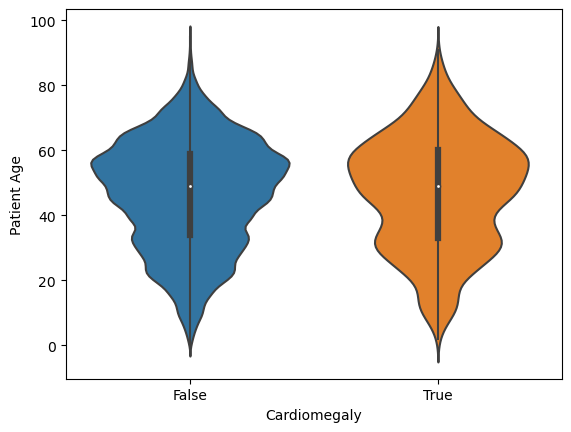

In [11]:
# Plot a violin plot for Patient Age separated by Cardiomegaly
sns.violinplot(data=data, y='Patient Age', x='Cardiomegaly');

The distributions of patient age are virtually identical between patients with and without cardiomegaly.

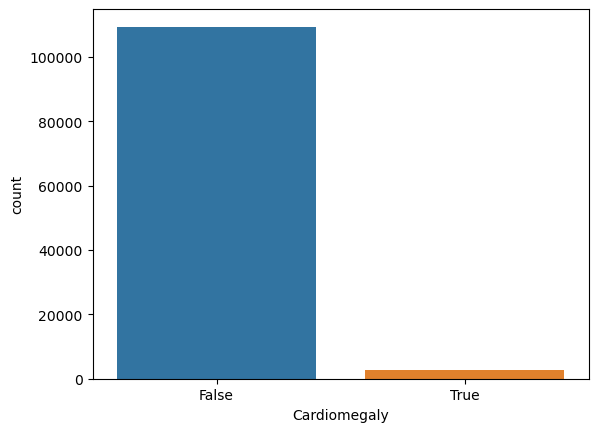

In [12]:
# Plot counts for Cardiomegaly
sns.countplot(data=data, x='Cardiomegaly');

The dataset is highly imbalanced towards images without cardiomegaly.

## 1.4 Loading images
Next I loaded the images and resized them to be smaller and thus more computationally efficient.

In [13]:
# Define the new size
newsize = (128, 128)

# Initialize the image list
image_list = []

# Define image directory, sort it and remove .DS_Store
directory = '../data/raw/all_images'
list_directory = os.listdir(directory)
list_directory.sort()
list_directory.remove('.DS_Store')

# Loop through each folder in the image directory
for folder in list_directory:
    image_directory = os.path.join(directory, folder)
    print(image_directory)
    
    # Load each image
    for img in os.listdir(image_directory):
        with Image.open(os.path.join(image_directory, img)) as f:
            # Convert CMYK images to Grayscale
            if f.mode == (1024, 1024):
                im = f
            else:
                im = f.convert('L')
            # Resize the image
            im = im.resize(newsize)
            # Convert to an array
            im_array = np.asarray(im)
            # Flatten
            im_flat = np.ndarray.flatten(im_array)
            # Append image_list
            image_list.append(im_flat)
# Stack all arrays
final_array = np.stack(image_list)

../data/raw/all_images/imagesA
../data/raw/all_images/imagesB
../data/raw/all_images/imagesC
../data/raw/all_images/imagesD
../data/raw/all_images/imagesE
../data/raw/all_images/imagesF
../data/raw/all_images/imagesG
../data/raw/all_images/imagesH
../data/raw/all_images/imagesI
../data/raw/all_images/imagesJ
../data/raw/all_images/imagesK
../data/raw/all_images/imagesL


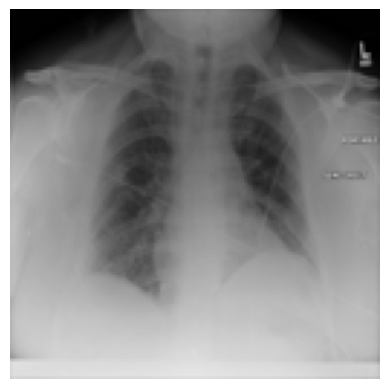

In [14]:
# Plot one image
im = final_array[0]
im = im.reshape(newsize)
plt.imshow(im, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

In [15]:
# Create DataFrame
df = pd.DataFrame(final_array)

In [16]:
# Create 'label' column using metadata
df['label'] = data['Cardiomegaly'].astype('int')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,16375,16376,16377,16378,16379,16380,16381,16382,16383,label
0,1,1,1,1,1,1,1,1,1,1,...,199,199,197,196,196,198,197,195,187,1
1,196,196,193,195,200,204,207,204,205,206,...,205,200,186,179,167,163,157,140,117,1
2,122,81,21,3,1,0,1,2,2,2,...,97,90,83,69,53,36,12,0,0,1
3,15,14,14,14,13,13,13,13,12,12,...,185,179,170,160,143,111,73,47,35,0
4,25,25,28,30,29,29,26,31,40,43,...,196,185,160,75,42,48,49,54,53,0


## 1.5 Undersampling
Due to the large number of images and high class imbalance, I undersampled the data, taking all Cardiomegaly samples and an equal number of negative samples.

In [17]:
# Sample df on label for 2776 of each class
sampled = df.groupby("label").sample(n=2776, random_state=1)
sampled.value_counts('label')

label
0    2776
1    2776
Name: count, dtype: int64

I now have a DataFrame with 2776 images of each positive and negative classes.

## 1.6 Visualizing Cardiomegaly

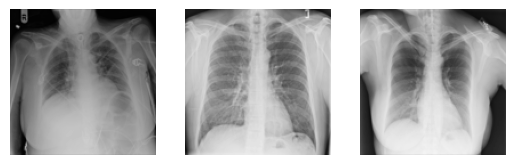

In [18]:
# Plot 3 examples with cardiomegaly
positive_examples = sampled.loc[sampled['label']==1].head(3).drop(columns=['label']).to_numpy()

fig, axes = plt.subplots(1, 3)
for ax, image in zip(axes, positive_examples):
    im = image.reshape(newsize)
    ax.imshow(im, cmap='gray', vmin=0, vmax=255)
    ax.axis('off')
plt.show()

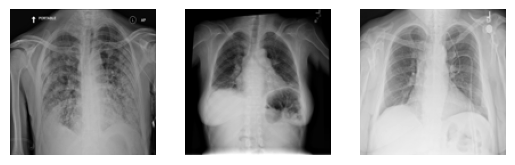

In [19]:
# Plot 3 examples without cardiomegaly
negative_examples = sampled.loc[sampled['label']==0].head(3).drop(columns=['label']).to_numpy()
fig, axes = plt.subplots(1, 3)
for ax, image in zip(axes, negative_examples):
    im = image.reshape(newsize)
    ax.imshow(im, cmap='gray', vmin=0, vmax=255)
    ax.axis('off')
plt.show()

## 1.7 Saving data

In [20]:
# Exporting sampled data as csv
sampled.to_csv('../data/processed/sampled_images.csv', index=False)